# Spectral-Spatial RF Pulses

Spectral-spatial RF pulses aim to provide both 
- spectral selection, typically to only excite protons in water molecules, and not protons in lipids
- spatial selection, for slice-selective imaging

These are particularly common in fMRI and diffusion with echo-planar imaging (EPI) in order to eliminate chemical shift displacement artifacts in the image, and are also used for water and/or fat suppression in MR spectroscopy.

## Learning Goals

1. Describe how images are formed
    * Understand how spectral-spatial RF pulses work
1. Identify artifacts and how to mitigate them
    * Determine when using spectral-spatial RF pulses would help remove chemical shift related artifacts

## Spectral-Spatial RF Pulse Design

This is done by creating a 2D excitation profile in both the spectral and spatial dimensions.  This is most easily interpreted through excitation k-space, where the RF energy deposited can be Fourier Transformed to reveal the approximate spectral-spatial profile created.

The gradient applied traverses spatial excitation k-space, while time traverses the spectral excitation k-space dimension, as demonstrated by the gradient and k-psace plot below

In [9]:
% setup MRI-education-resources path and requirements
cd ../
startup

% trick to compile abr() mex file
abr([1 1], [0 0], 0);

loading image
loading signal


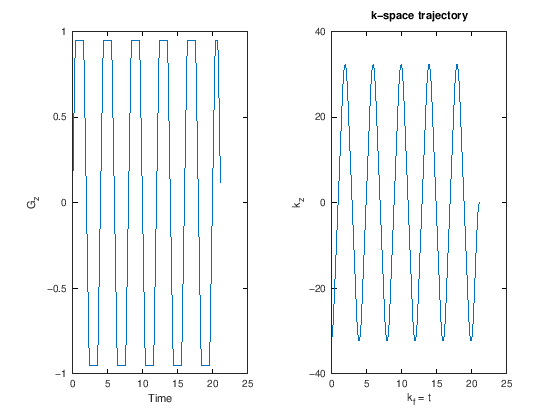

In [4]:
% Demonstrate gradient and spectral-spatial k-space trajectoy

GAMMA = 42.58;
dt = 0.1;

Nlobe = 20;
Nspec = 10;
Nramp = 4;

ramp = [.5:Nramp-.5]/Nramp;
g1 = [ramp, ones(1,Nlobe-2*Nramp), ramp(end:-1:1)]; 

gamp = 0.95;
g = [];
for k = 1:Nspec
   g = [g, (mod(k,2)*2 - 1)*gamp*g1];
end

Nrw = round((Nlobe - Nramp)/2 + Nramp);
grw = [ramp, ones(1,Nrw-2*Nramp), ramp(end:-1:1)];

g = [g, (mod(Nspec+1,2)*2-1)*gamp*grw];

t = [0:length(g)-1]*dt;
subplot(121)
plot(t, g)
ylabel('G_z')
xlabel('Time')

subplot(122)
plot(t, GAMMA*dt*(cumsum(g) - sum(g)))
xlabel('k_f = t'), ylabel('k_z')
title('k-space trajectory')


To design the RF pulse, we can approximate the pulse and profile shape as separable function in frequency and space:

$$ h(f,z) = h_f(f) h_z(z)$$
$$ \mathcal{F}\{ h(f,z) \} = H(k_f, k_z) = H_f(k_f) H_z(k_z)$$

With this approximation, we can formulate the goal of the RF pulse design is to create and combine two pulses:
- A spectral pulse filter, $H_f(k_f)$, that should be applied in $k_f$ direction
- A spatial pulse filter, $H_z(k_z)$, that should be applied in the $k_z$ direction

Then design typically consists of 3 main steps
1. Design spectral pulse (envelope)
2. Design spatial sub-pulse
3. Combine spectral pulse envelope and spatial subpulses with an oscillating gradient

In [17]:
% Design parameters
GAMMA = 4258; % Hz/G
slewmax = 15e3; % G/cm/s
gmax = 4; % G/cm
T = 20e-3; % ms
TBW = 3;
SBW = 6;
dz = 0.5; % cm, max spatial resolution
Nspec = 10;
DT = T/Nspec;
dt = 10e-6; % us
flip = pi/4;

% gradient parameters
verse_frac = 0.8;
Nlobe = DT/dt;
Nspat = round(Nlobe * verse_frac);
Nwait = (Nlobe - Nspat)/2;

z = linspace(-0.8, 0.8, 201);
df = linspace(-500, 500, 201);


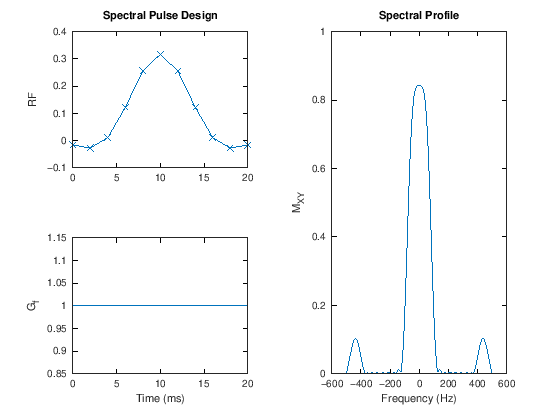

In [15]:
% 1. Spectral Pulse Design

rfspec = dzrf(Nspec, TBW);
gf = 2*pi*DT * ones(1,length(rfspec));
mxy_f = ab2ex(abr(rfspec, gf, df));

t = [0:length(rfspec)-1]*DT*1e3;
subplot(221)
plot(t, real(rfspec), '-x')
ylabel('RF')
title('Spectral Pulse Design')
subplot(223)
plot(t, ones(1,length(rfspec)))
ylabel('G_f')
xlabel('Time (ms)')
subplot(122)
plot(df, abs(mxy_f))
xlabel('Frequency (Hz)'), ylabel('M_{XY}')
title('Spectral Profile')

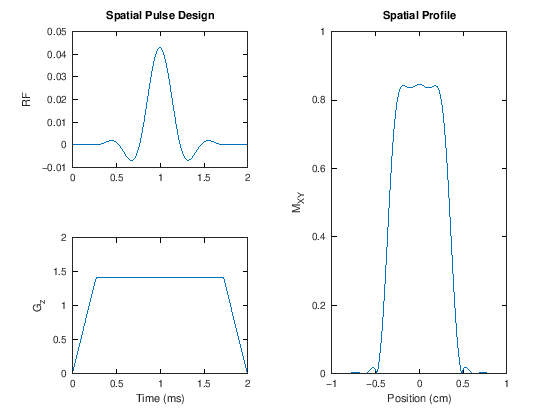

In [25]:
% 2. Spatial pulse design

rfspat = dzrf(Nspat, SBW);

% gradients (including ramp sampling)
gamp = (SBW/DT)/(GAMMA*dz); % gradient for spatial resolution

% Uses a slew rate that can't be violated
Nramp = min( ceil(gmax/slewmax / dt), floor(Nlobe/2));
ramp = [.5:Nramp-.5]/Nramp;
g1 = [ramp, ones(1,Nlobe-2*Nramp), ramp(end:-1:1)]; 
% apply VERSE algorithm for time-varying gradient
rfspatv = verse(g1, [zeros(1, floor(Nwait)), rfspat(:).', zeros(1,ceil(Nwait))]).';
rfspatv(find(isnan(rfspatv))) = 0;

g1z = 2*pi*GAMMA*dt * gamp* g1;
mxy_z = ab2ex(abr(rfspatv, g1z, z));

t = [0:length(g1)-1]*dt*1e3;
subplot(221)
plot(t, real(rfspatv))
ylabel('RF')
title('Spatial Pulse Design')

subplot(223)
plot(t, gamp*g1)
ylabel('G_z')
xlabel('Time (ms)')

subplot(122)
plot(z, abs(mxy_z))
xlabel('Position (cm)'), ylabel('M_{XY}')
title('Spatial Profile')


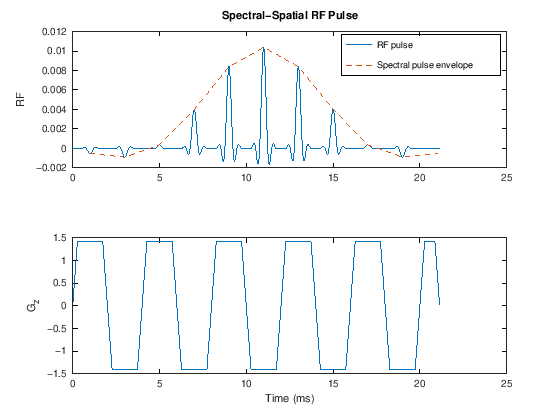

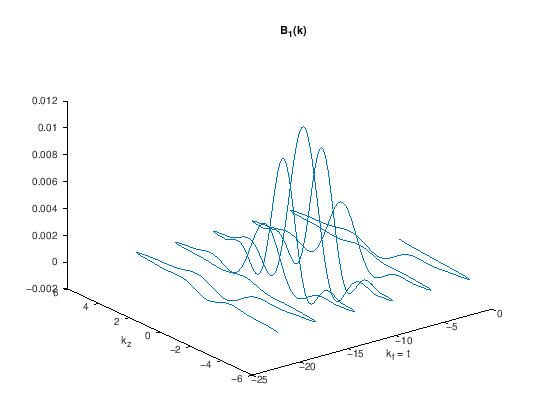

In [33]:
% 3. Combine spectral and spatial pulse designs

rf = []; g = [];
for k = 1:Nspec
   rf = [rf, rfspatv*rfspec(k)];  % weight spatial sub-pulses by the spectral filter
   g = [g, (mod(k,2)*2 - 1)*gamp*g1];  % oscillate gradient
end

% add spatial refocusing gradient
Nrw = round((Nlobe - Nramp)/2 + Nramp);
grw = [ramp, ones(1,Nrw-2*Nramp), ramp(end:-1:1)];

g = [g, (mod(Nspec+1,2)*2-1)*gamp*grw];
rf = [rf, zeros(1,Nrw)];

% scale RF pulse
flip_scale = flip/sum(rf);
rf = flip_scale*rf;
rfs = rfscaleg(rf, T);

figure
subplot(211)
plot([0:length(rf)-1]*dt*1e3, real(rf), ...
    [0.5:1:length(rfspec)-0.5]*DT*1e3, real(rfspec)/max(real(rfspec)) * max(real(rf)), '--')
    legend('RF pulse', 'Spectral pulse envelope')
ylabel('RF')
title('Spectral-Spatial RF Pulse')
subplot(212)
plot([0:length(rf)-1]*dt*1e3, g)
ylabel('G_z')
xlabel('Time (ms)')

figure
plot3([-length(rf)+1:0]*dt*1e3, GAMMA*dt*(cumsum(g) - sum(g)), real(rf))
xlabel('k_f = t'), ylabel('k_z')
title('B_1(k)')



The spectral pulse, $H_f(k_f)$, creates the overall envelope, and is applied as a weighting for repeated versions of the spatial pulse, $H_z(k_z)$.  This creates the excitation k-space profile, $B_1(k_f, k_z)$ shown above, which results in the spectral-spatial profile shown below:

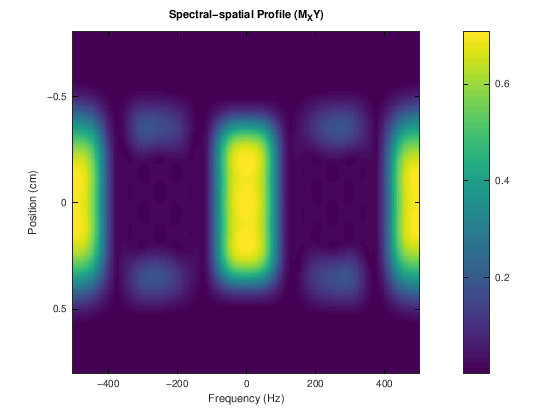

In [32]:

gz = 2*pi*GAMMA*dt * g;
gf = 2*pi*dt * ones(1,length(rf));

mxy_2d = ab2ex(abr(rf, gz + i*gf, z, df));


figure
imagesc(df,z,abs(mxy_2d))
xlabel('Frequency (Hz)'), ylabel('Position (cm)')
title('Spectral-spatial Profile (M_XY)')
%colormap(gray)
colorbar



Watch how the transverse magnetization evolves during the spectral-spatial RF pulse:

![spectral_spatial_RF_animation.gif](images/spectral_spatial_RF_animation.gif)